# Experiment

In [ ]:
import pandas as pd
from fastai.tabular.all import *

In [ ]:
df1 = pd.read_csv("./rsqa-indice-qualite-air-2022-2024.csv")
df2 = pd.read_csv("./rsqa-indice-qualite-air-2019-2021.csv")
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df.isna().sum()

stationId    0
valeur       0
dtype: int64

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = df['date'] + pd.to_timedelta(df['heure'], unit='h')
df.head()

,stationId,polluant,valeur,date,heure,datetime
0,103,O3,15,2022-01-15,3,2022-01-15 03:00:00
1,103,NO2,2,2022-01-15,3,2022-01-15 03:00:00
2,103,PM,12,2022-01-15,3,2022-01-15 03:00:00
3,17,CO,1,2022-02-04,21,2022-02-04 21:00:00
4,17,O3,17,2022-02-04,21,2022-02-04 21:00:00


In [ ]:
df = df.sort_values(by='datetime')
df.set_index('datetime', inplace=True)

In [ ]:
df.drop(['date', 'heure', 'polluant'], axis=1, inplace=True)
df

,stationId,valeur
datetime,,
2019-01-01 00:00:00,50,36
2019-01-01 00:00:00,55,37
2019-01-01 00:00:00,28,7
2019-01-01 00:00:00,7,3
2019-01-01 00:00:00,80,1
...,...,...
2024-04-09 23:00:00,3,7
2024-04-09 23:00:00,3,1
2024-04-09 23:00:00,3,2


In [ ]:
# Feature engineering
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

Index([2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019,
       ...
       2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024],
      dtype='int32', name='datetime', length=1789045)

# Run

In [56]:
import pandas as pd
from fastai.tabular.all import *

# Data is from Jan 2022 -> April 2024
# df = pd.read_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv')
df = pd.read_csv('./rsqa-indice-qualite-air-2022-2024.csv')

split_date_valid = pd.Timestamp('2023-06-01')
split_date_test = pd.Timestamp('2024-01-01')

df['date'] = pd.to_datetime(df['date'])
df['datetime'] = df['date'] + pd.to_timedelta(df['heure'], unit='h')
df.sort_values(by='datetime', inplace=True)
df.set_index('datetime', inplace=True)
df.drop(['date', 'heure', 'polluant', 'stationId'], axis=1, inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

train_idx = df.index < split_date_valid
valid_idx = (df.index >= split_date_valid) & (df.index < split_date_test)
test_idx = df.index >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

(478431, 478432, 671374, 671375)

In [79]:
dls = TabularPandas(
  df.reset_index(),
  procs=[Normalize],
  cat_names=[],
  cont_names=['year', 'month', 'day', 'weekday', 'hour'],
  y_names=['valeur'],
  splits=(train_idxs, valid_idxs)
).dataloaders(bs=1200)

dls.show_batch()

,year,month,day,weekday,hour,valeur
0,2022.0,10.0,3.0,-8.693833e-08,9.000000e+00,10.0
1,2022.0,4.0,9.0,5.000000e+00,2.200000e+01,3.0
2,2022.0,5.0,12.0,3.000000e+00,5.000000e+00,9.0
3,2022.0,9.0,29.0,3.000000e+00,1.183974e-07,1.0
4,2022.0,7.0,1.0,4.000000e+00,1.100000e+01,33.0
5,2023.0,1.0,21.0,5.000000e+00,1.000000e+01,1.0
6,2022.0,4.0,9.0,5.000000e+00,1.300000e+01,28.0
7,2023.0,4.0,19.0,2.000000e+00,4.000000e+00,3.0
8,2023.0,5.0,23.0,1.000000e+00,1.800000e+01,25.0
9,2022.0,6.0,14.0,1.000000e+00,3.000000e+00,1.0


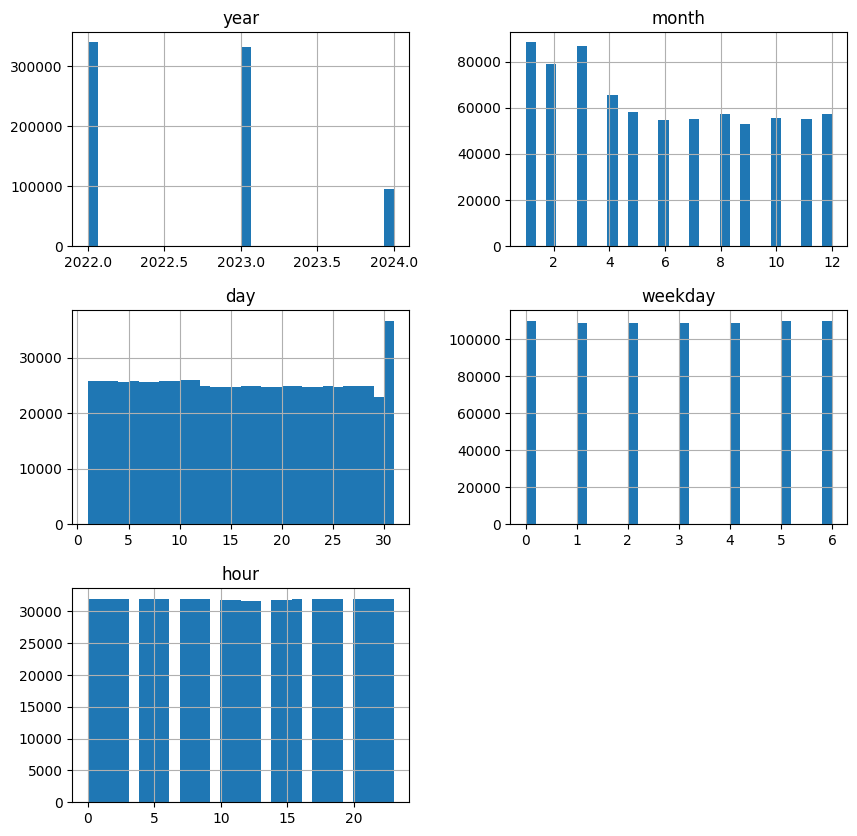

In [48]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with continuous features
df[['year', 'month', 'day', 'weekday', 'hour']].hist(bins=30, figsize=(10, 10))
plt.show()

In [80]:
learn = tabular_learner(dls, metrics=accuracy, layers=[100, 100])

SuggestedLRs(valley=0.005248074419796467, slide=0.00013182566908653826)

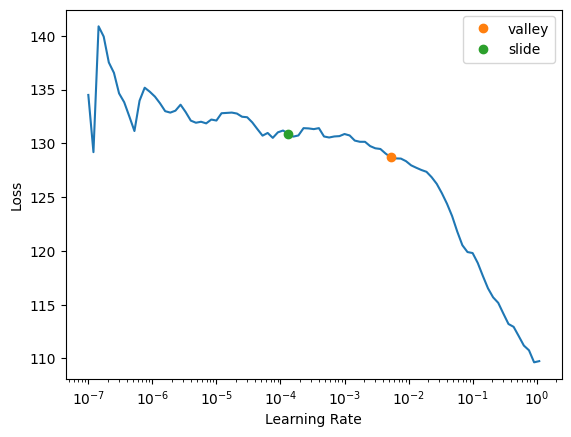

In [81]:
learn.lr_find(suggest_funcs=[valley, slide])

In [ ]:
learn.fit_one_cycle(5, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,65.705978,153.981552,0.026878,00:08
1,66.751366,155.001266,0.026878,00:08
2,68.725128,154.837631,0.026878,00:09
3,65.473312,155.525894,0.026878,00:07


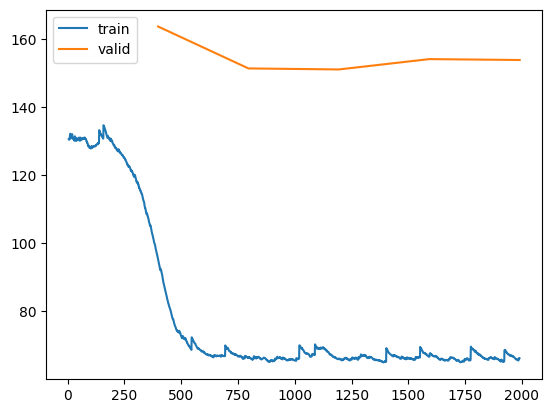

In [83]:
learn.recorder.plot_loss()